In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(bdkn)

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Warning message:
“package ‘bdkn’ was built under R version 3.5.2”
Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%

Loading ychr


In [2]:
samples <- c("den8", "a00", "S_French_1", "S_Dinka_1", "ustishim", "neand", "elsidron1", "elsidron2")

In [3]:
full_gt <- read_gt(here("data/vcf/merged_full.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))
lippold_gt <- read_gt(here("data/vcf/merged_lippold.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))
exome_gt <- read_gt(here("data/vcf/merged_exome.vcf.gz"), var_only = TRUE) %>% select(chrom, pos, REF, ALT, one_of(samples))

Warning message:
“Unknown columns: `elsidron1`, `elsidron2`”Warning message:
“Unknown columns: `elsidron1`”Warning message:
“Unknown columns: `elsidron2`”

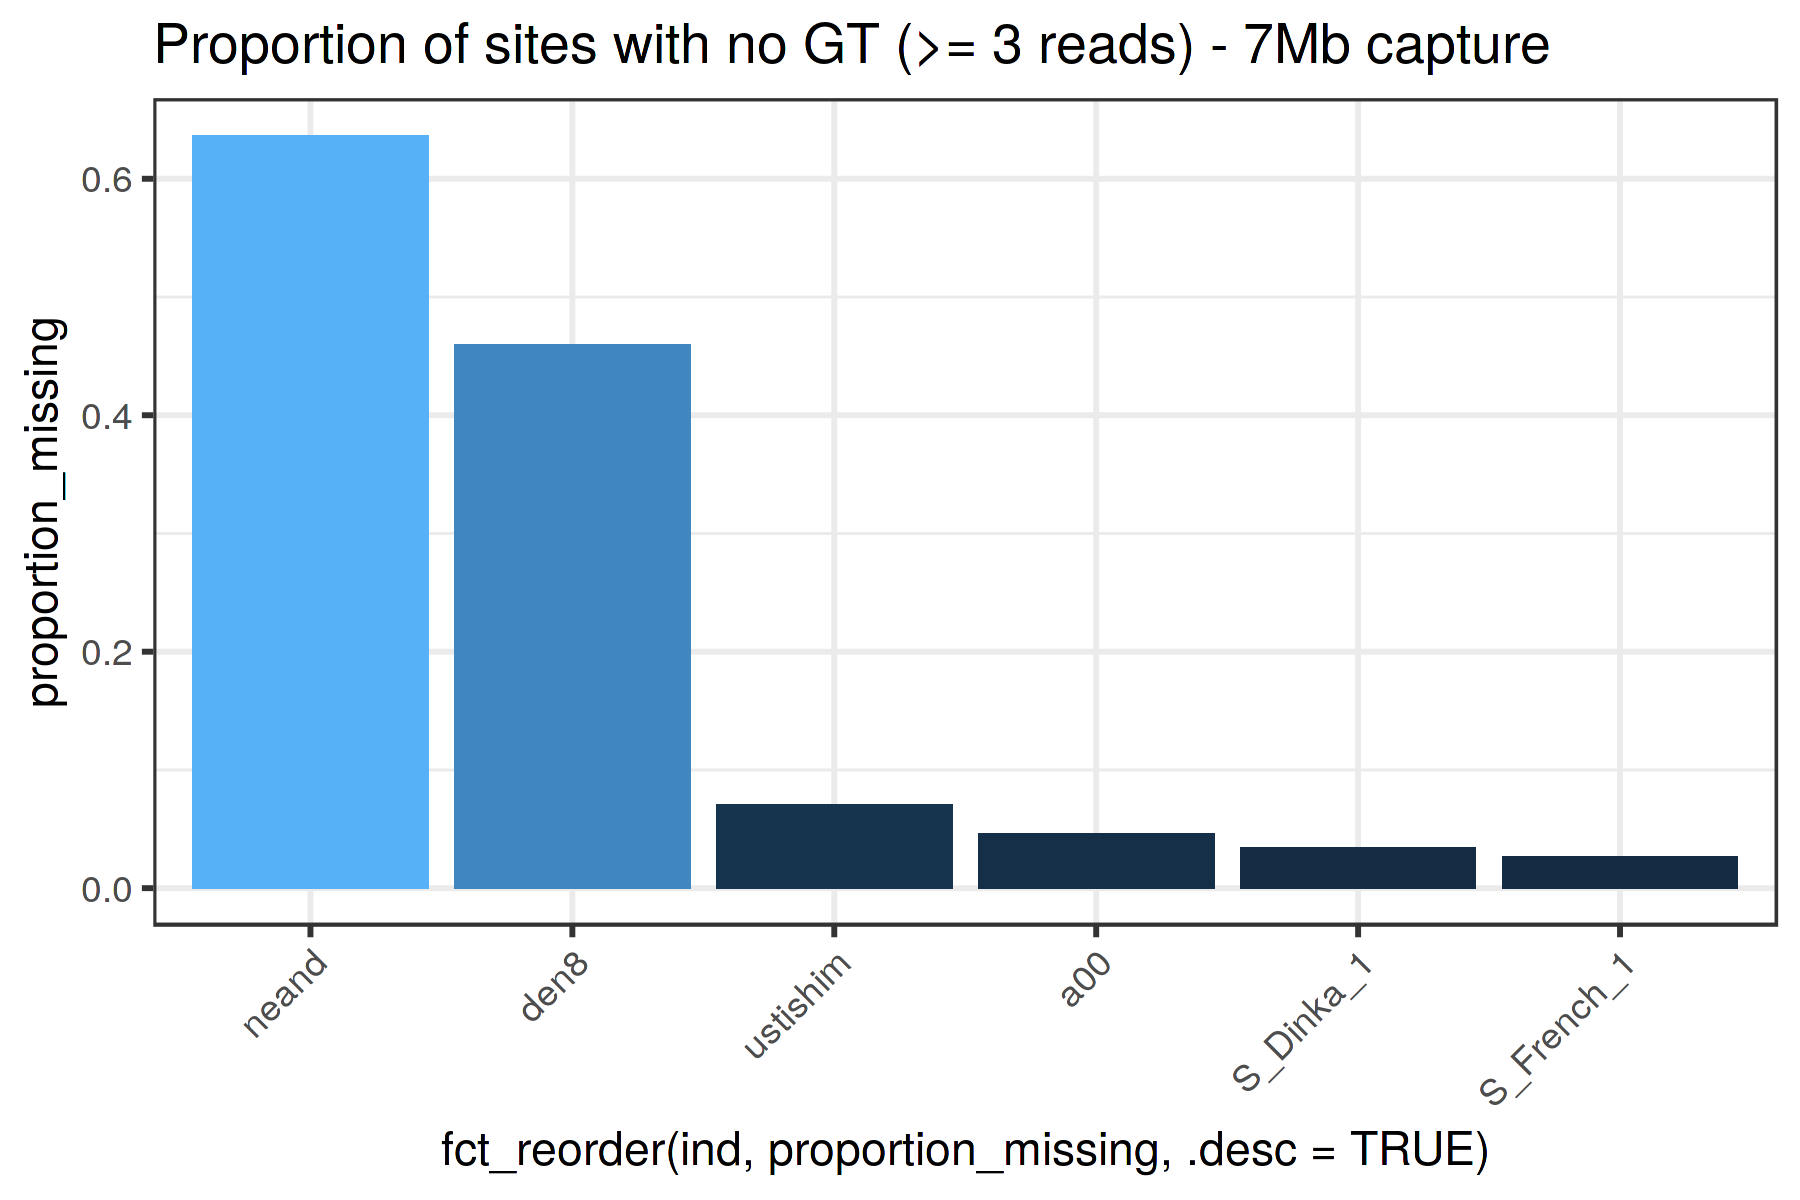

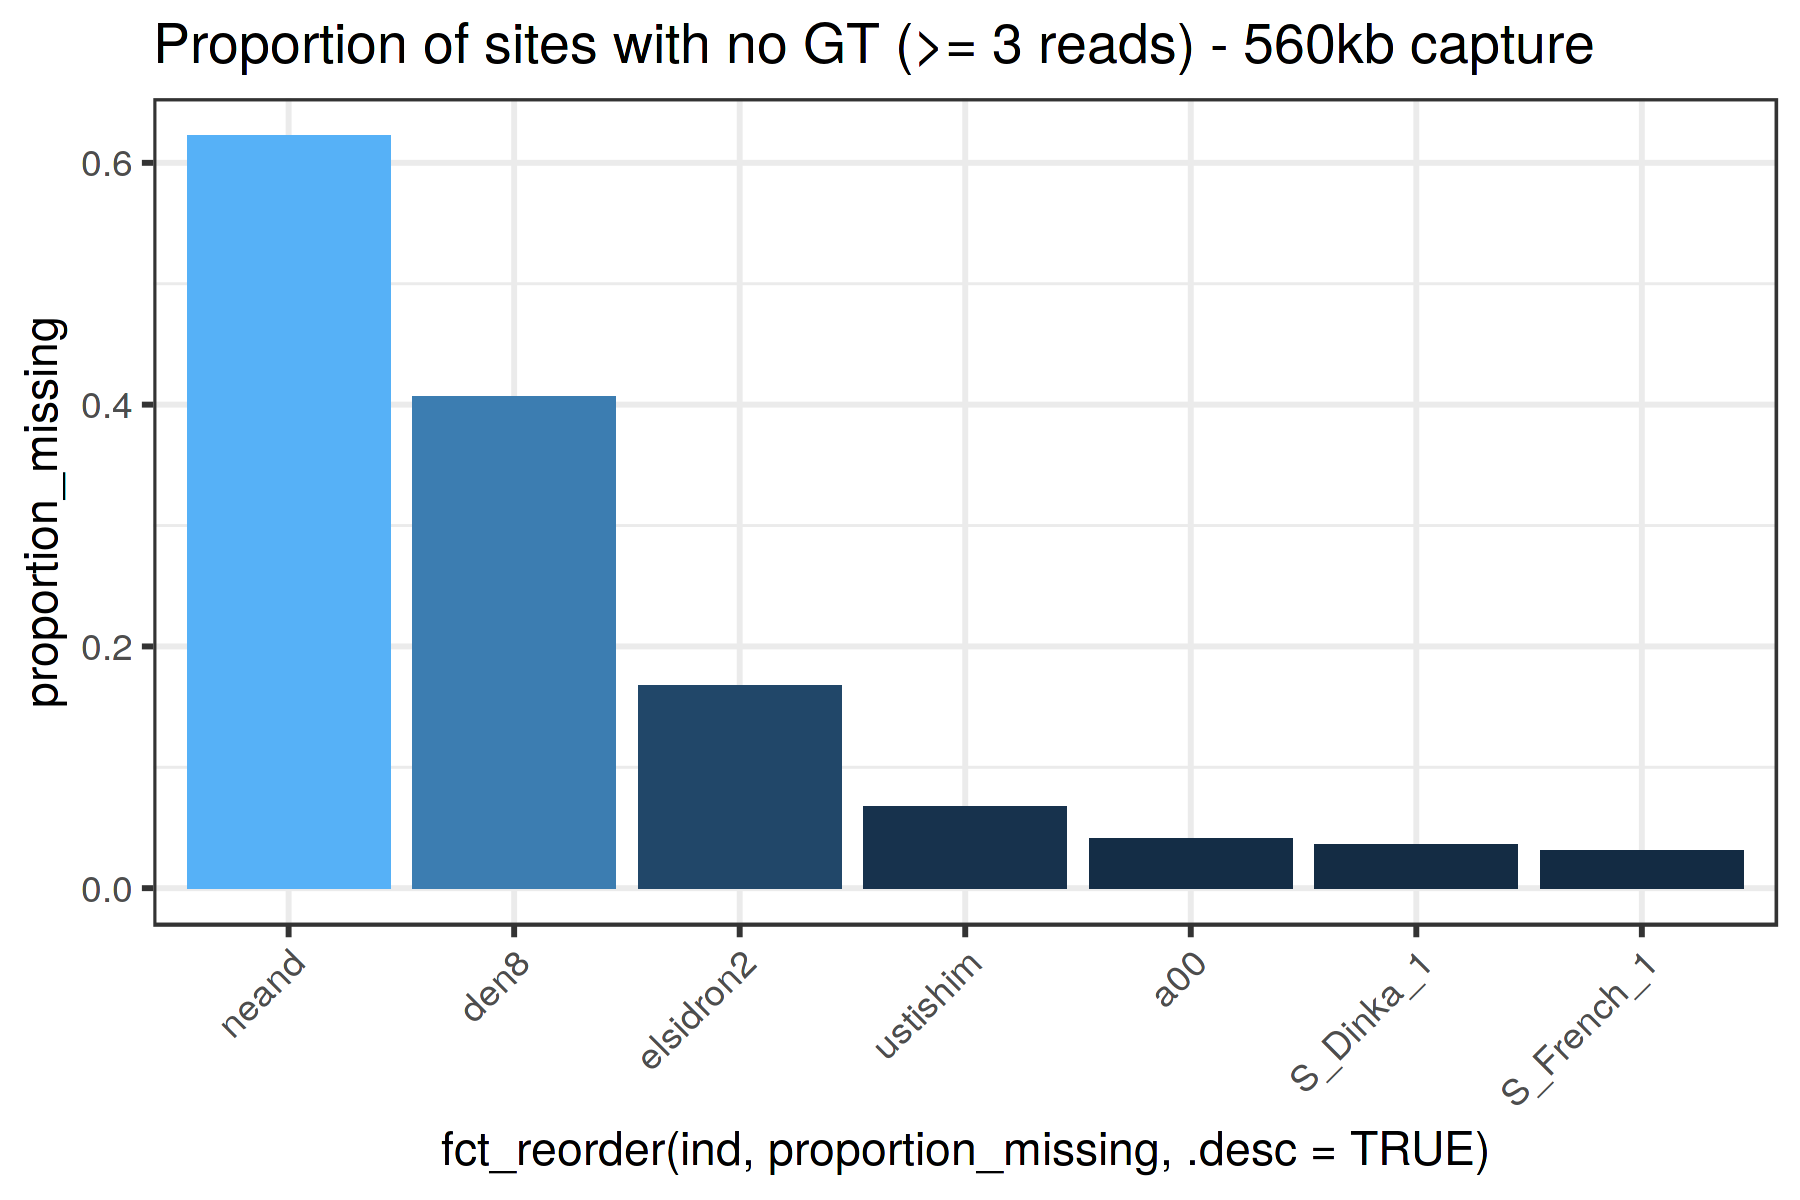

In [5]:
set_dim(6, 4)

select(full_gt, -c(chrom, pos, REF, ALT)) %>%
summarise_all(~ mean(is.na(.), na.rm = TRUE)) %>%
gather(ind, proportion_missing) %>%
ggplot(aes(fct_reorder(ind, proportion_missing, .desc = TRUE), proportion_missing, fill = proportion_missing)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of sites with no GT (>= 3 reads) - 7Mb capture") +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

select(lippold_gt, -c(chrom, pos, REF, ALT)) %>%
summarise_all(~ mean(is.na(.), na.rm = TRUE)) %>%
gather(ind, proportion_missing) %>%
ggplot(aes(fct_reorder(ind, proportion_missing, .desc = TRUE), proportion_missing, fill = proportion_missing)) +
    geom_bar(stat = "identity") +
    ggtitle("Proportion of sites with no GT (>= 3 reads) - 560kb capture") +
    theme_bw() +
    theme(legend.position = "none", axis.text.x = element_text(hjust = 1, angle = 45))

In [6]:
full_props <- snp_props(full_gt, normalize = FALSE)
lippold_props <- snp_props(lippold_gt, normalize = FALSE)
exome_props <- snp_props(exome_gt, normalize = FALSE)

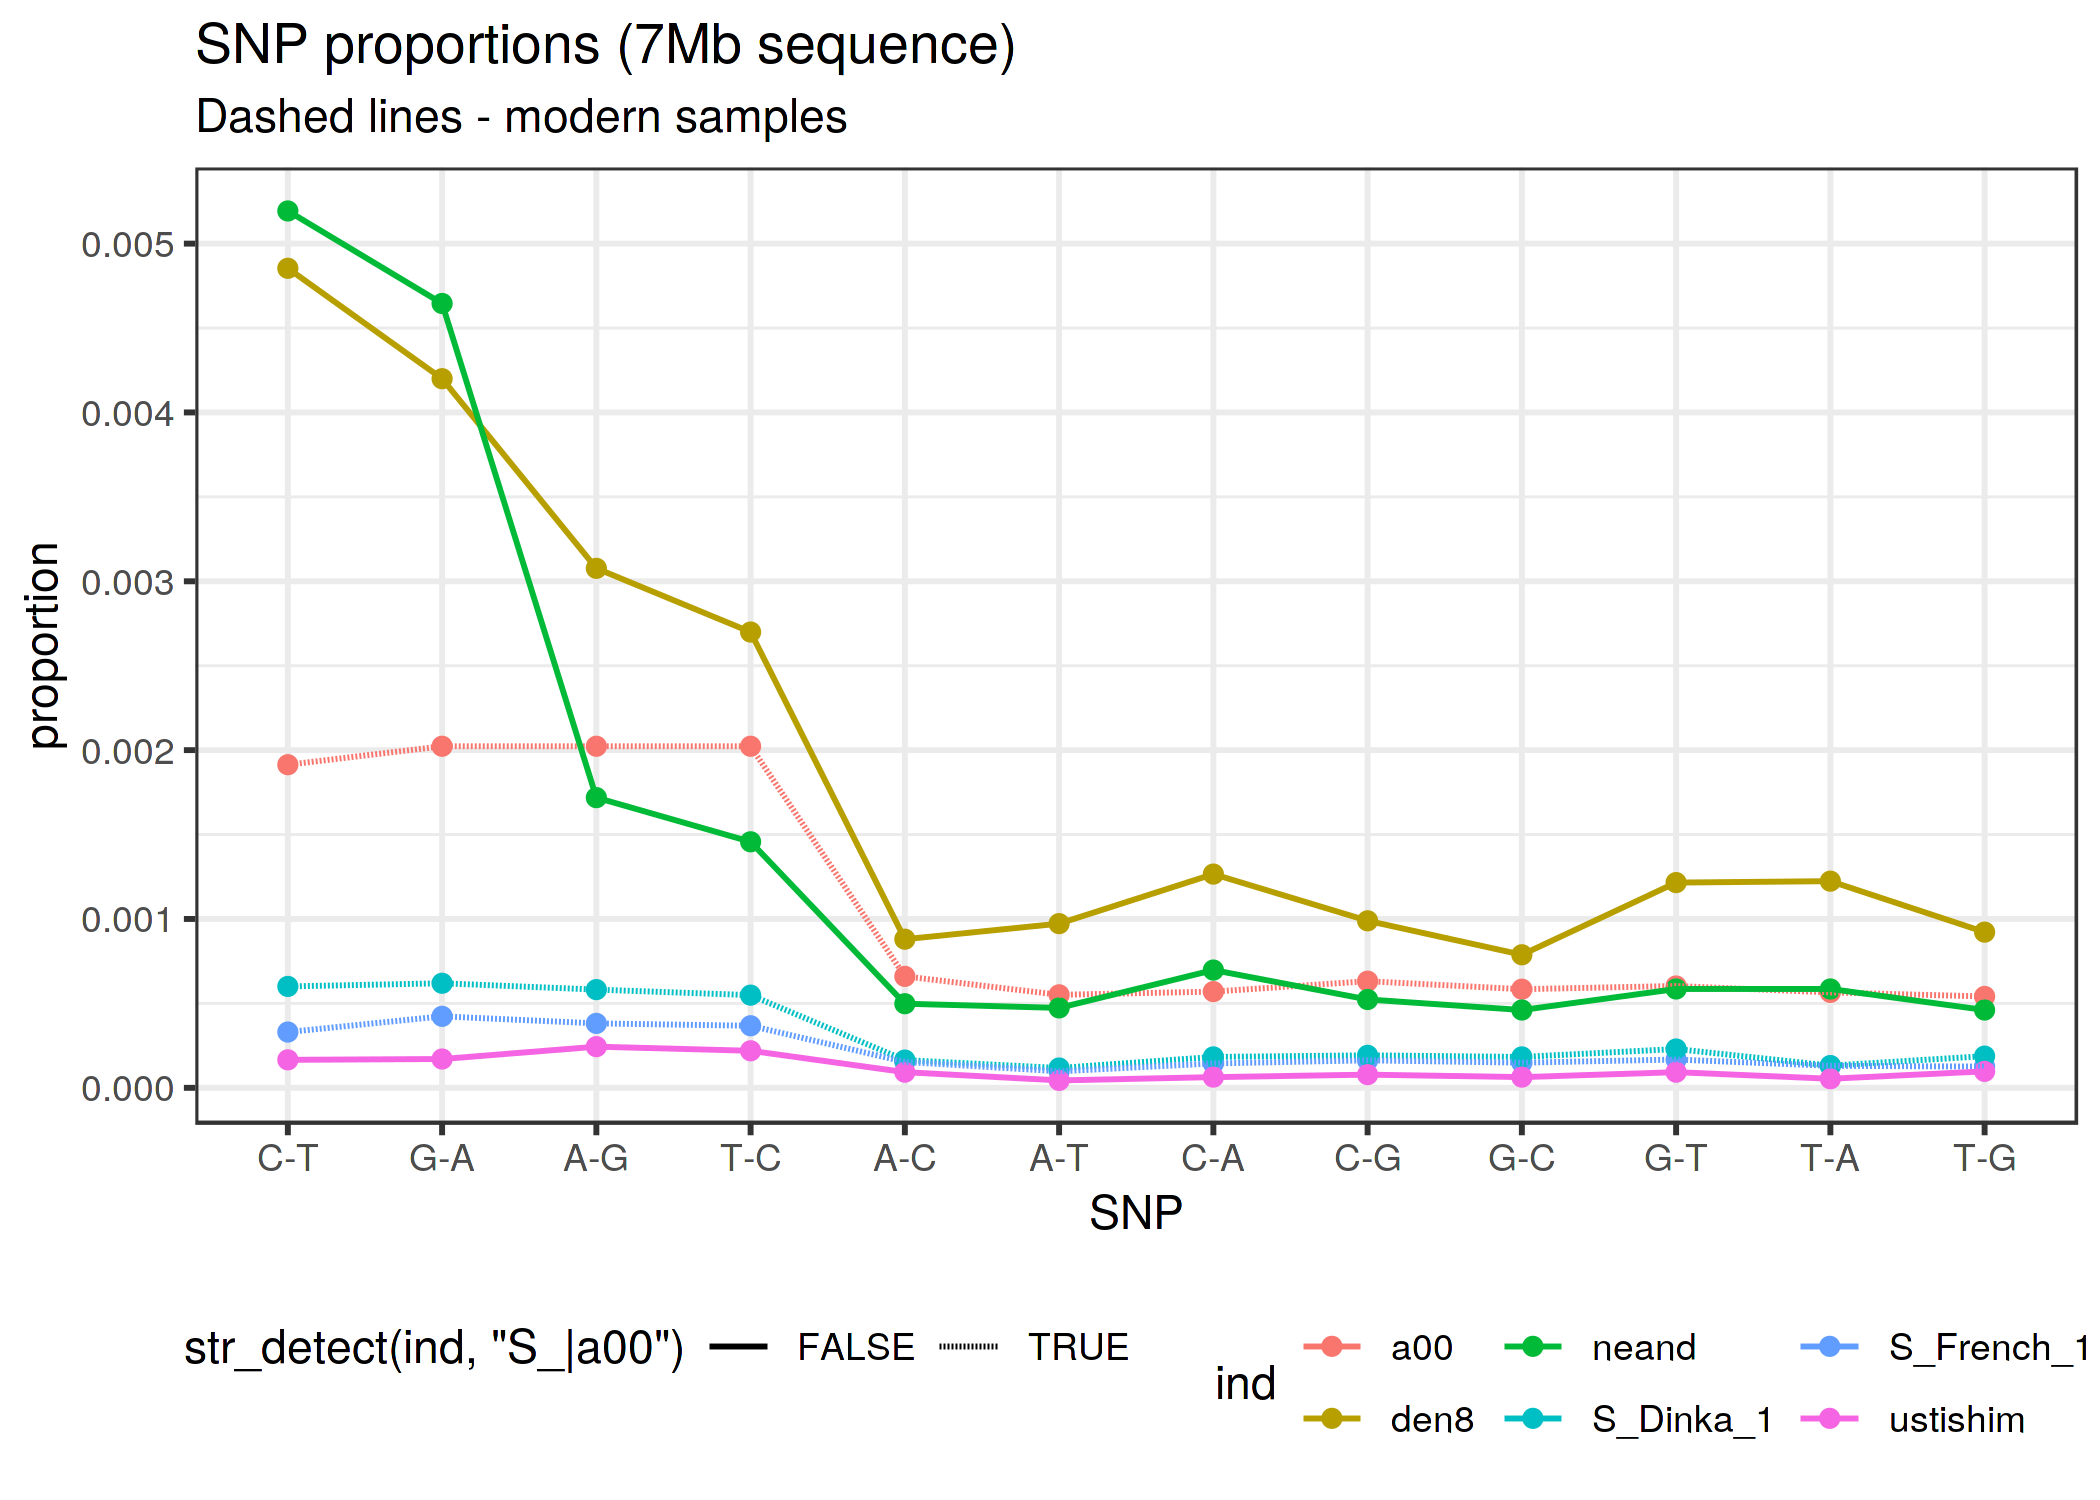

In [7]:
set_dim(7, 5)

full_props %>%
gather(ind, proportion, -snp) %>%
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point() +
    geom_line(aes(group = ind, linetype = str_detect(ind, "S_|a00"))) +
    theme_bw() +
    xlab("SNP") +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions (7Mb sequence)",
            "Dashed lines - modern samples")

# Testing the coverage cutoff for Denisova 8

In [8]:
read_dp <- function(name, path, dp) {
    read_gt(path, mindp = dp, var_only = TRUE) %>%
        .[, c("chrom", "pos", name)] %>%
        setNames(c("chrom", "pos", name %+% "_dp" %+% dp))
}

In [9]:
den8_gt <- bind_cols(
    read_dp("den8", here("data/vcf/test_cov.vcf.gz"), dp = 1),
    map(2:4, ~ read_dp("den8", here("data/vcf/test_cov.vcf.gz"), dp = .x) %>% select(-chrom, -pos))
)

In [10]:
neand_gt <- bind_cols(
    read_dp("neand", here("data/vcf/test_cov.vcf.gz"), dp = 1),
    map(2:4, ~ read_dp("neand", here("data/vcf/test_cov.vcf.gz"), dp = .x) %>% select(-chrom, -pos))
)

In [11]:
lowcov_gt <- inner_join(den8_gt, neand_gt, by = c("chrom", "pos"))

In [12]:
highcov_gt <- read_gt(here("data/vcf/test_cov.vcf.gz")) %>%
    select(chrom, pos, REF, ALT, a00, S_French_1, S_Dinka_1)

In [13]:
gt <- inner_join(highcov_gt, lowcov_gt)

Joining, by = c("chrom", "pos")


In [31]:
test_props <- snp_props(gt, normalize = "T-C")

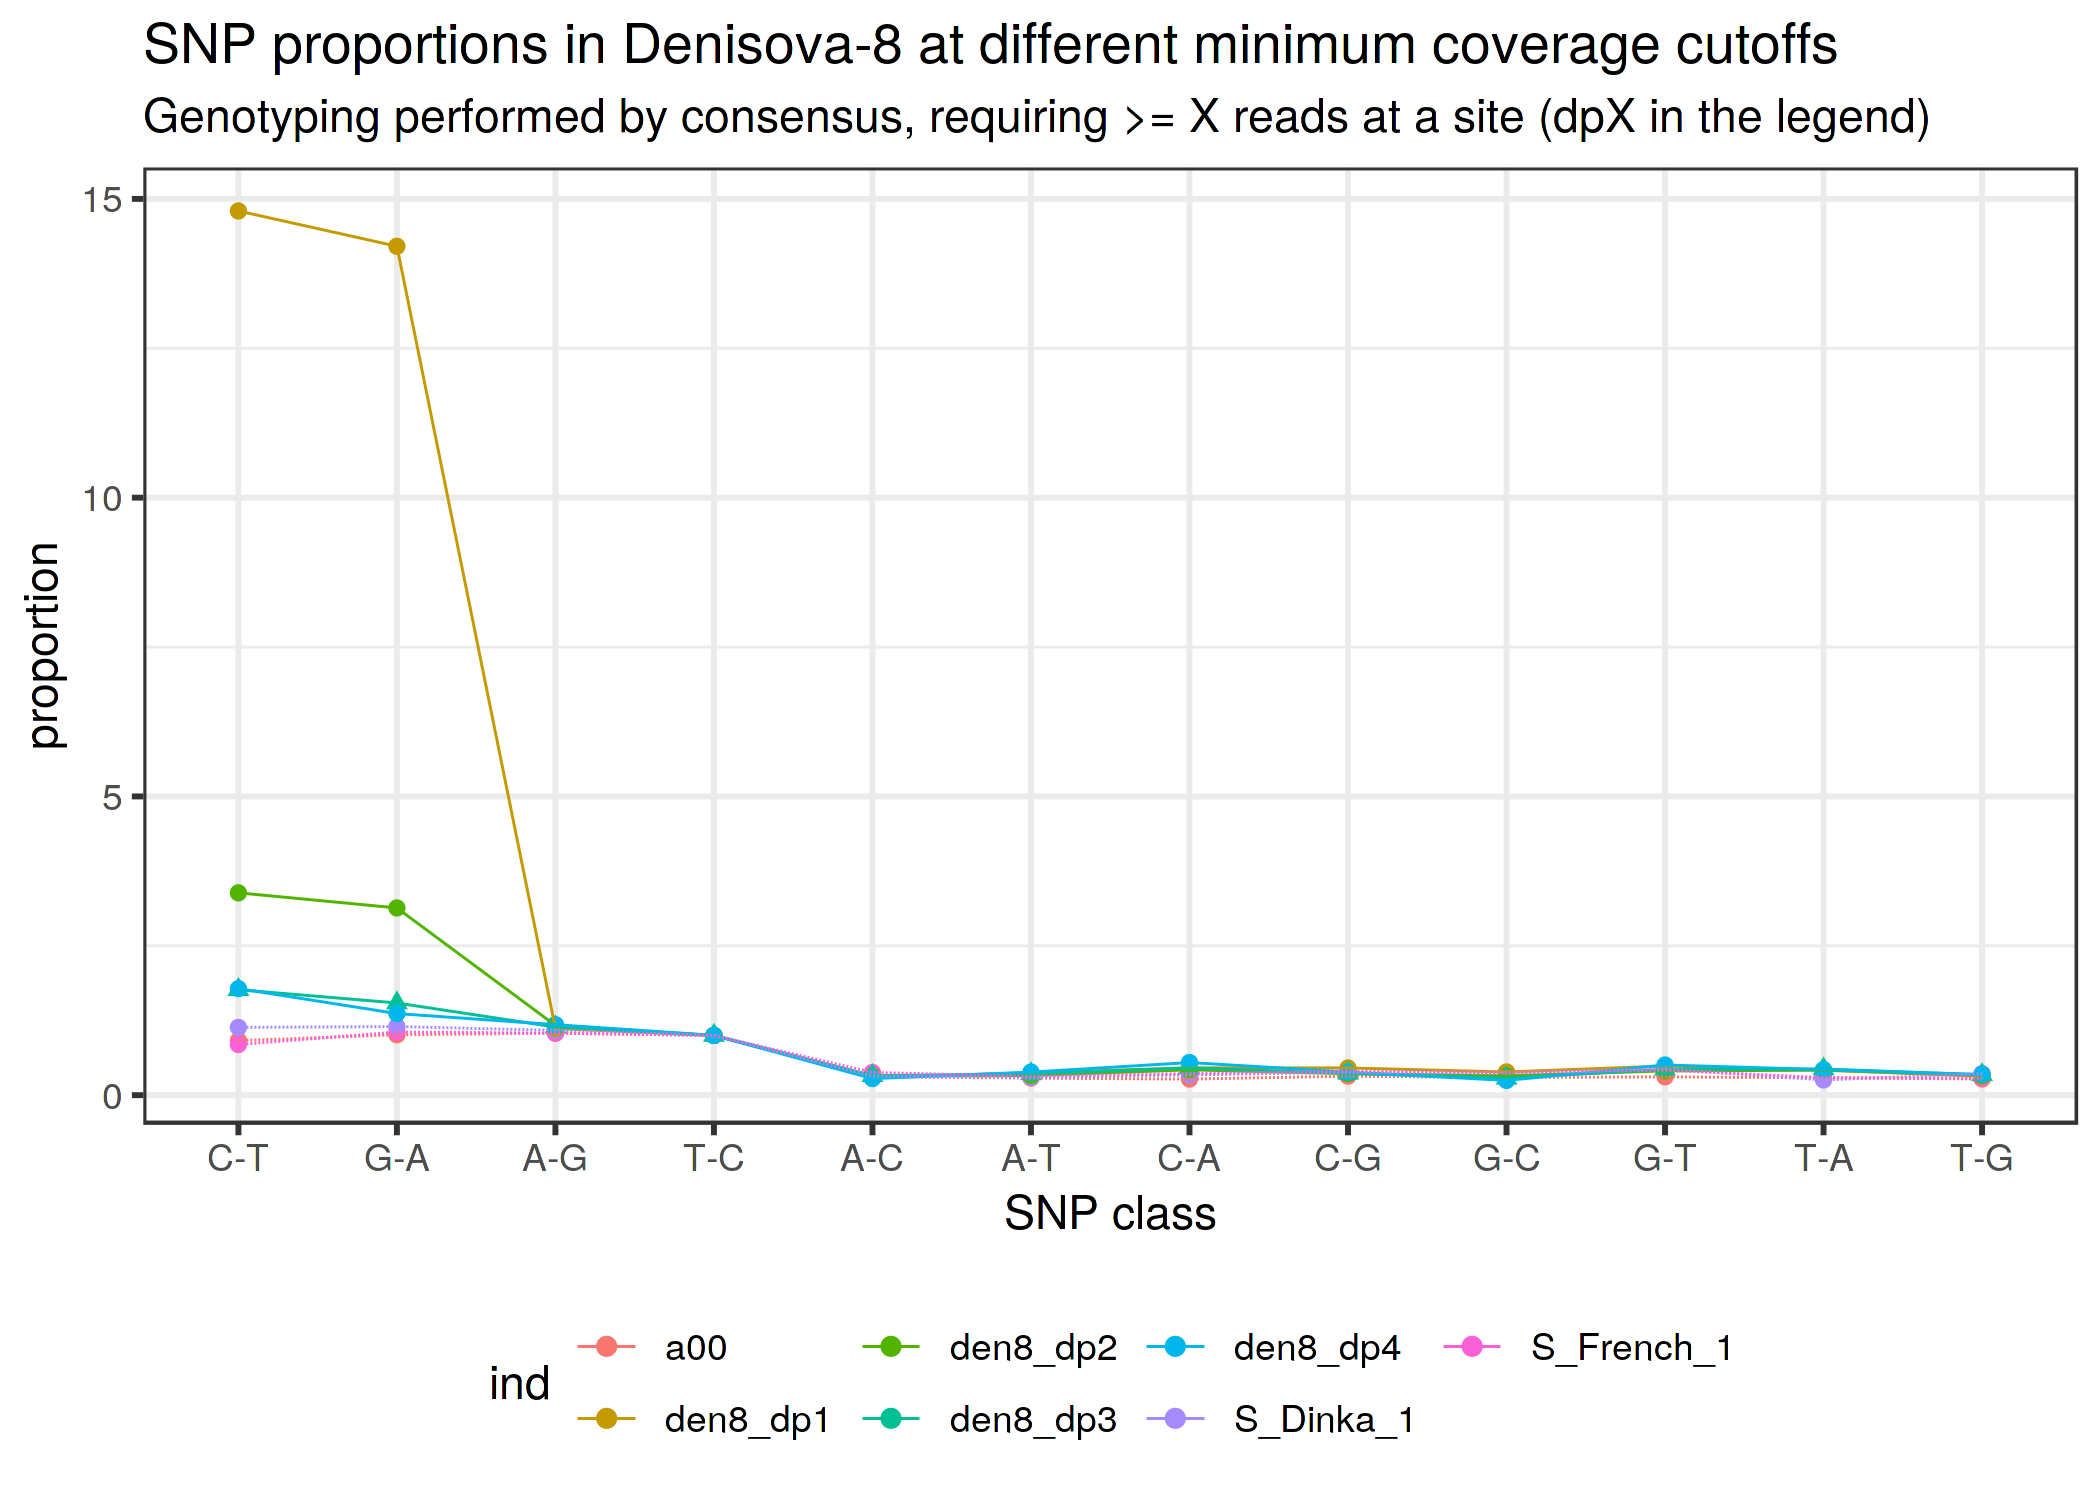

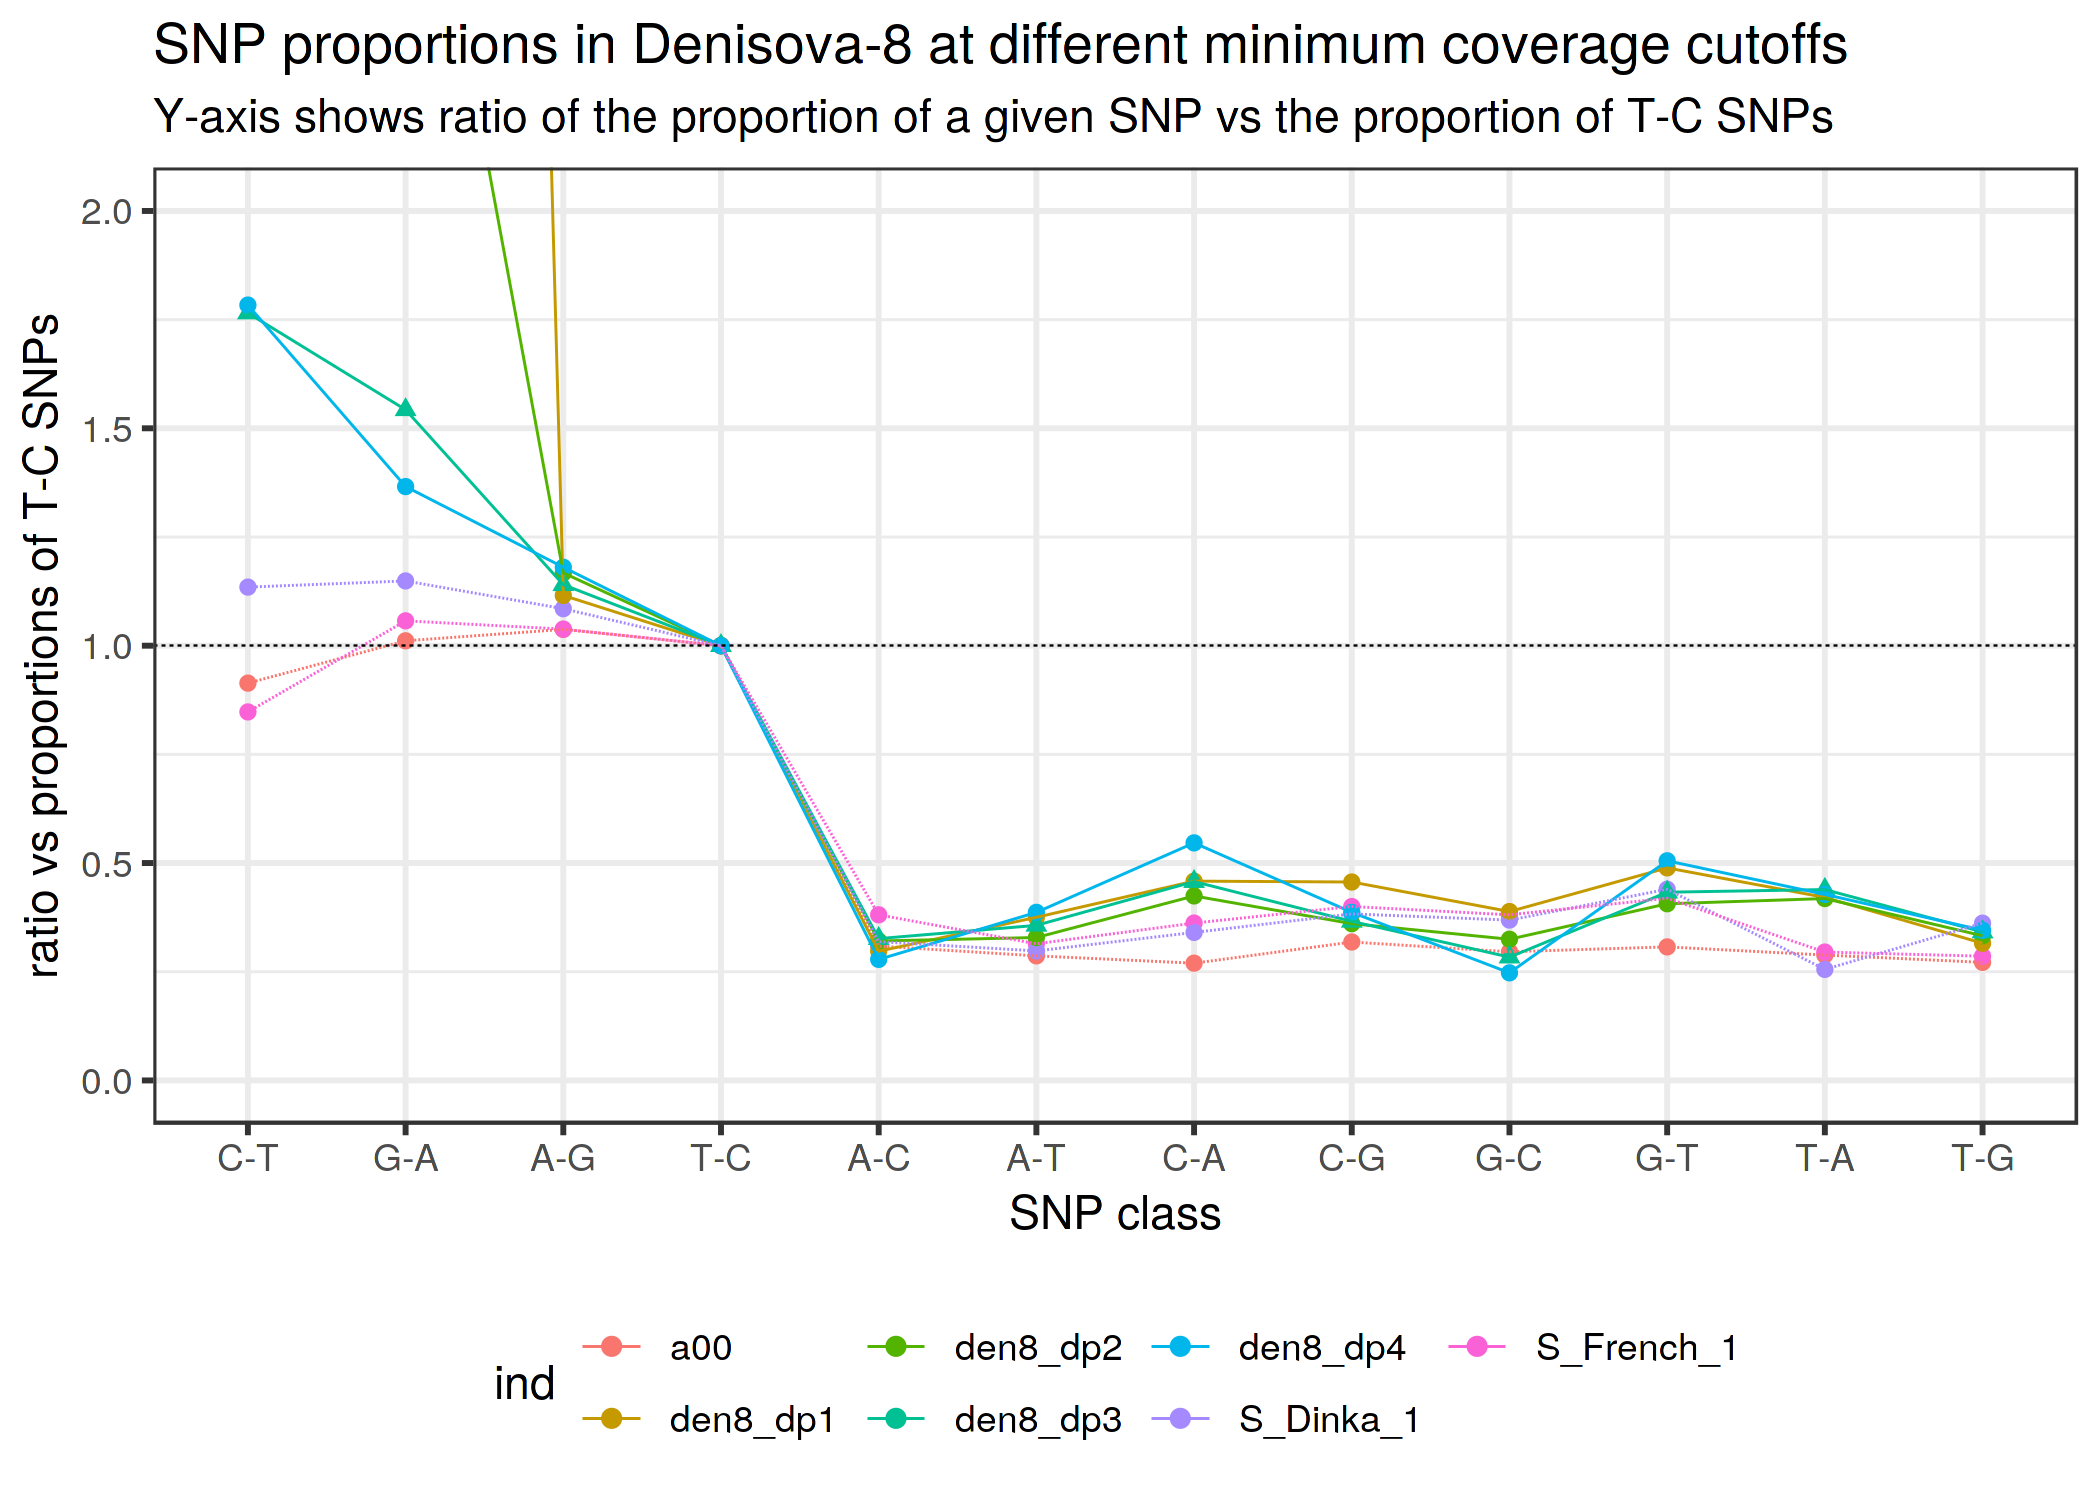

In [32]:
set_dim(7, 5)

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "neand")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = str_detect(ind, "dp3"))) +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Genotyping performed by consensus, requiring >= X reads at a site (dpX in the legend)")

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "neand")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = str_detect(ind, "dp3"))) +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "den8")), size = 0.25) +
    theme_bw() + ylab("ratio vs proportions of T-C SNPs") +
    xlab("SNP class") +
    geom_hline(yintercept = 1, linetype = 2, size = 0.2) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    coord_cartesian(y = c(0, 2)) +
    ggtitle("SNP proportions in Denisova-8 at different minimum coverage cutoffs",
            "Y-axis shows ratio of the proportion of a given SNP vs the proportion of T-C SNPs")

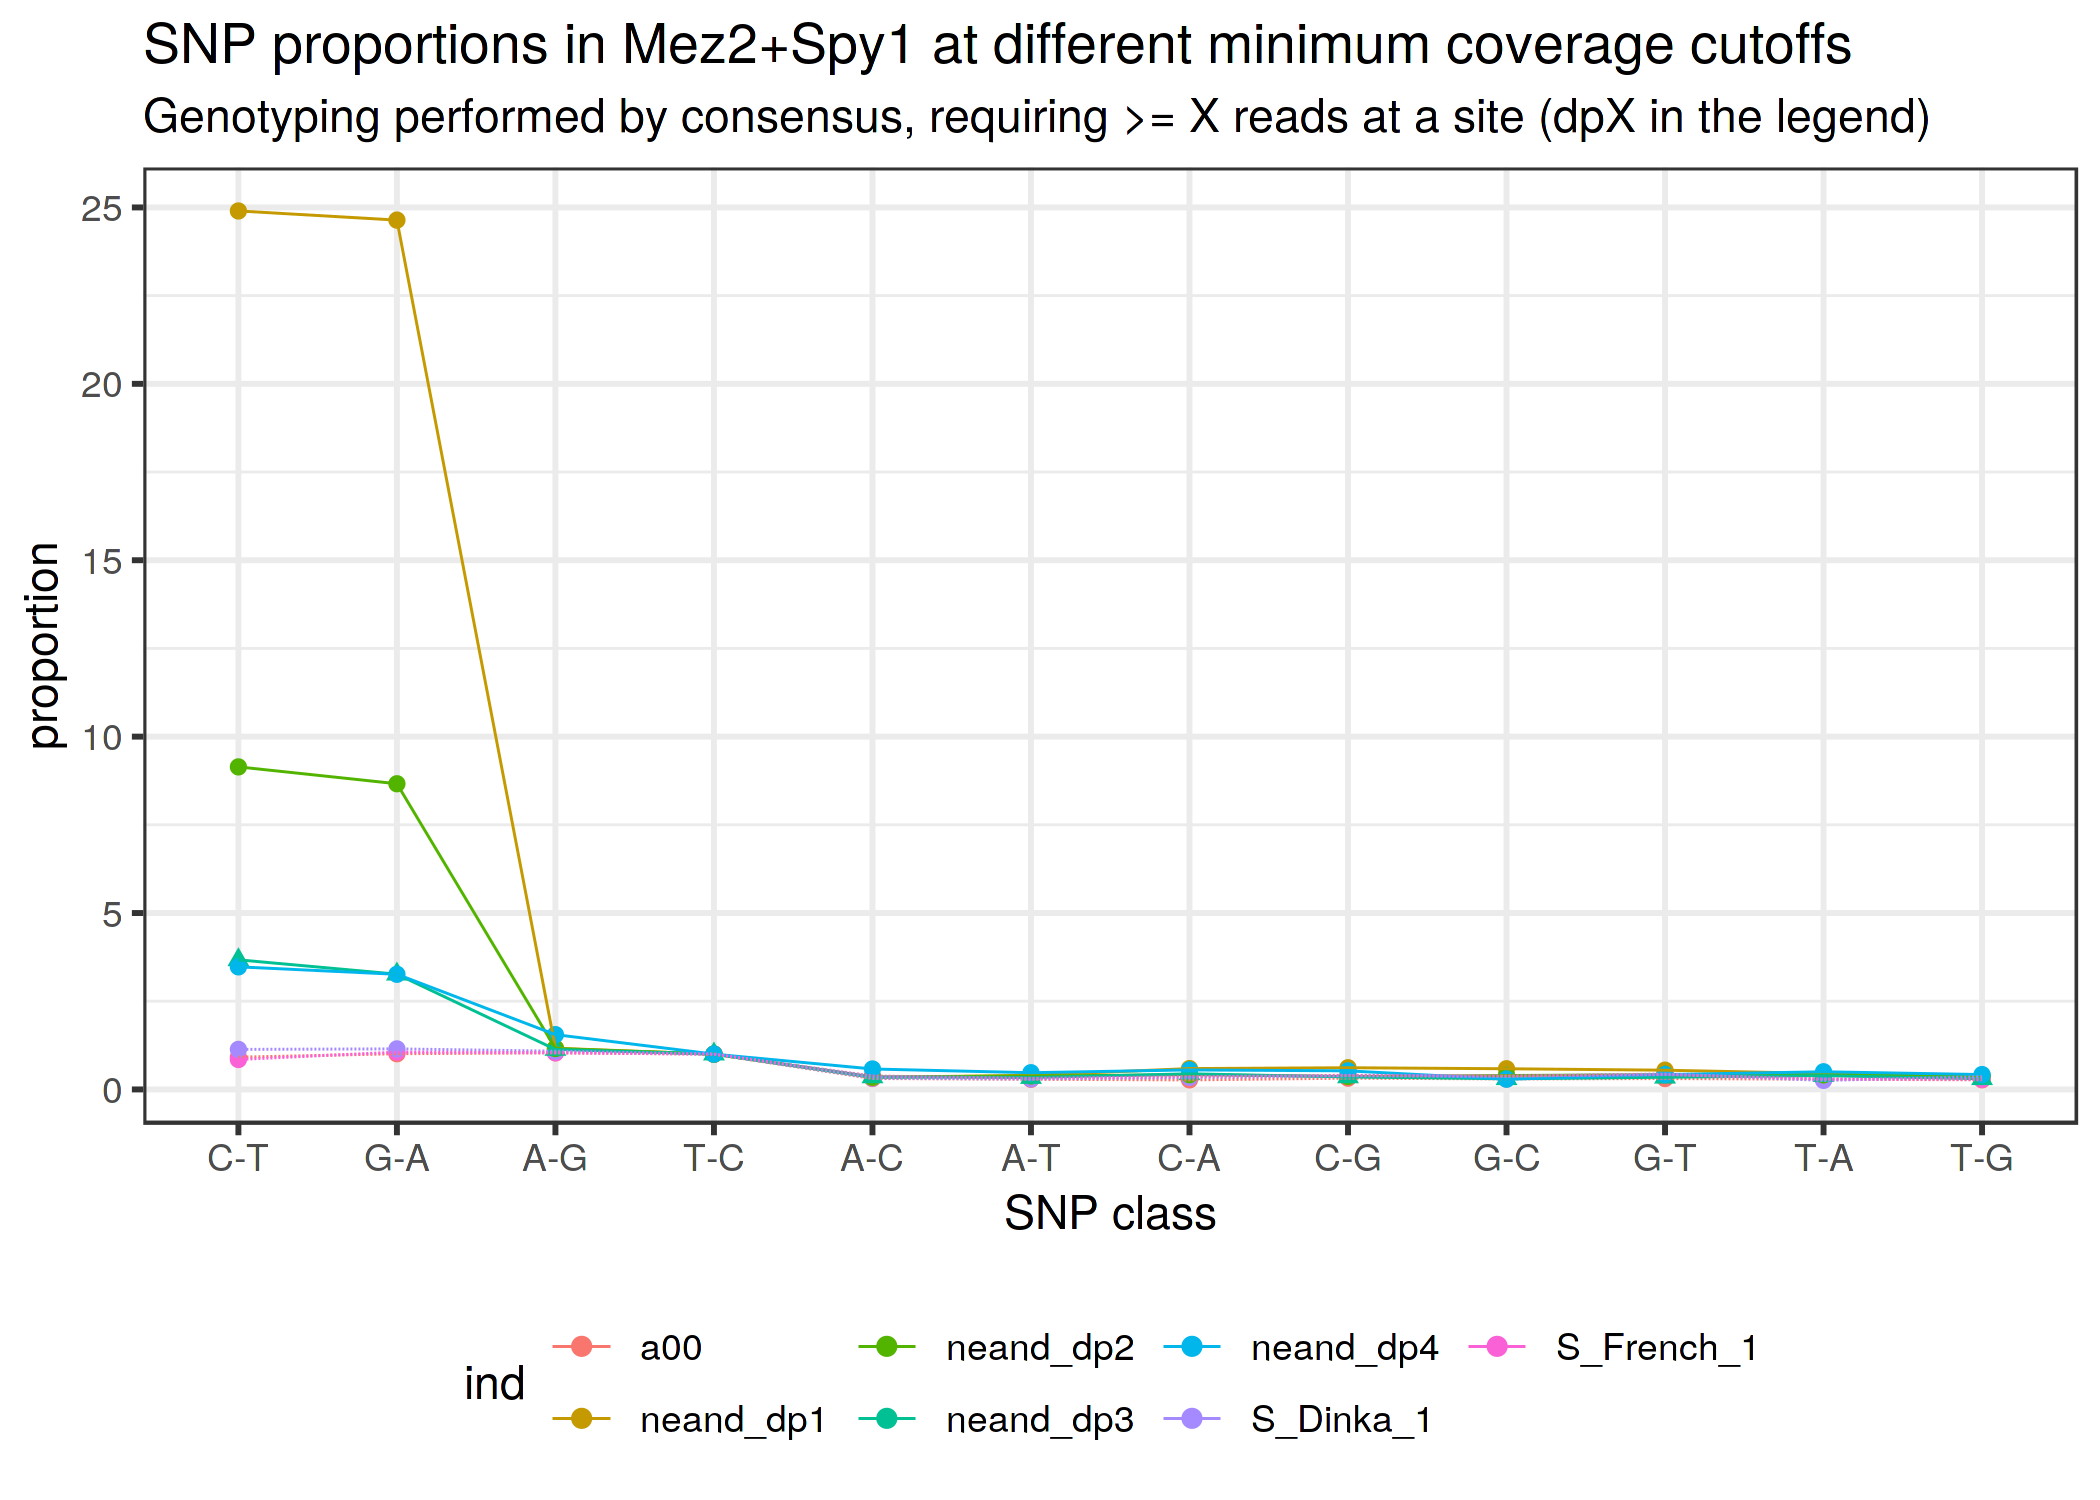

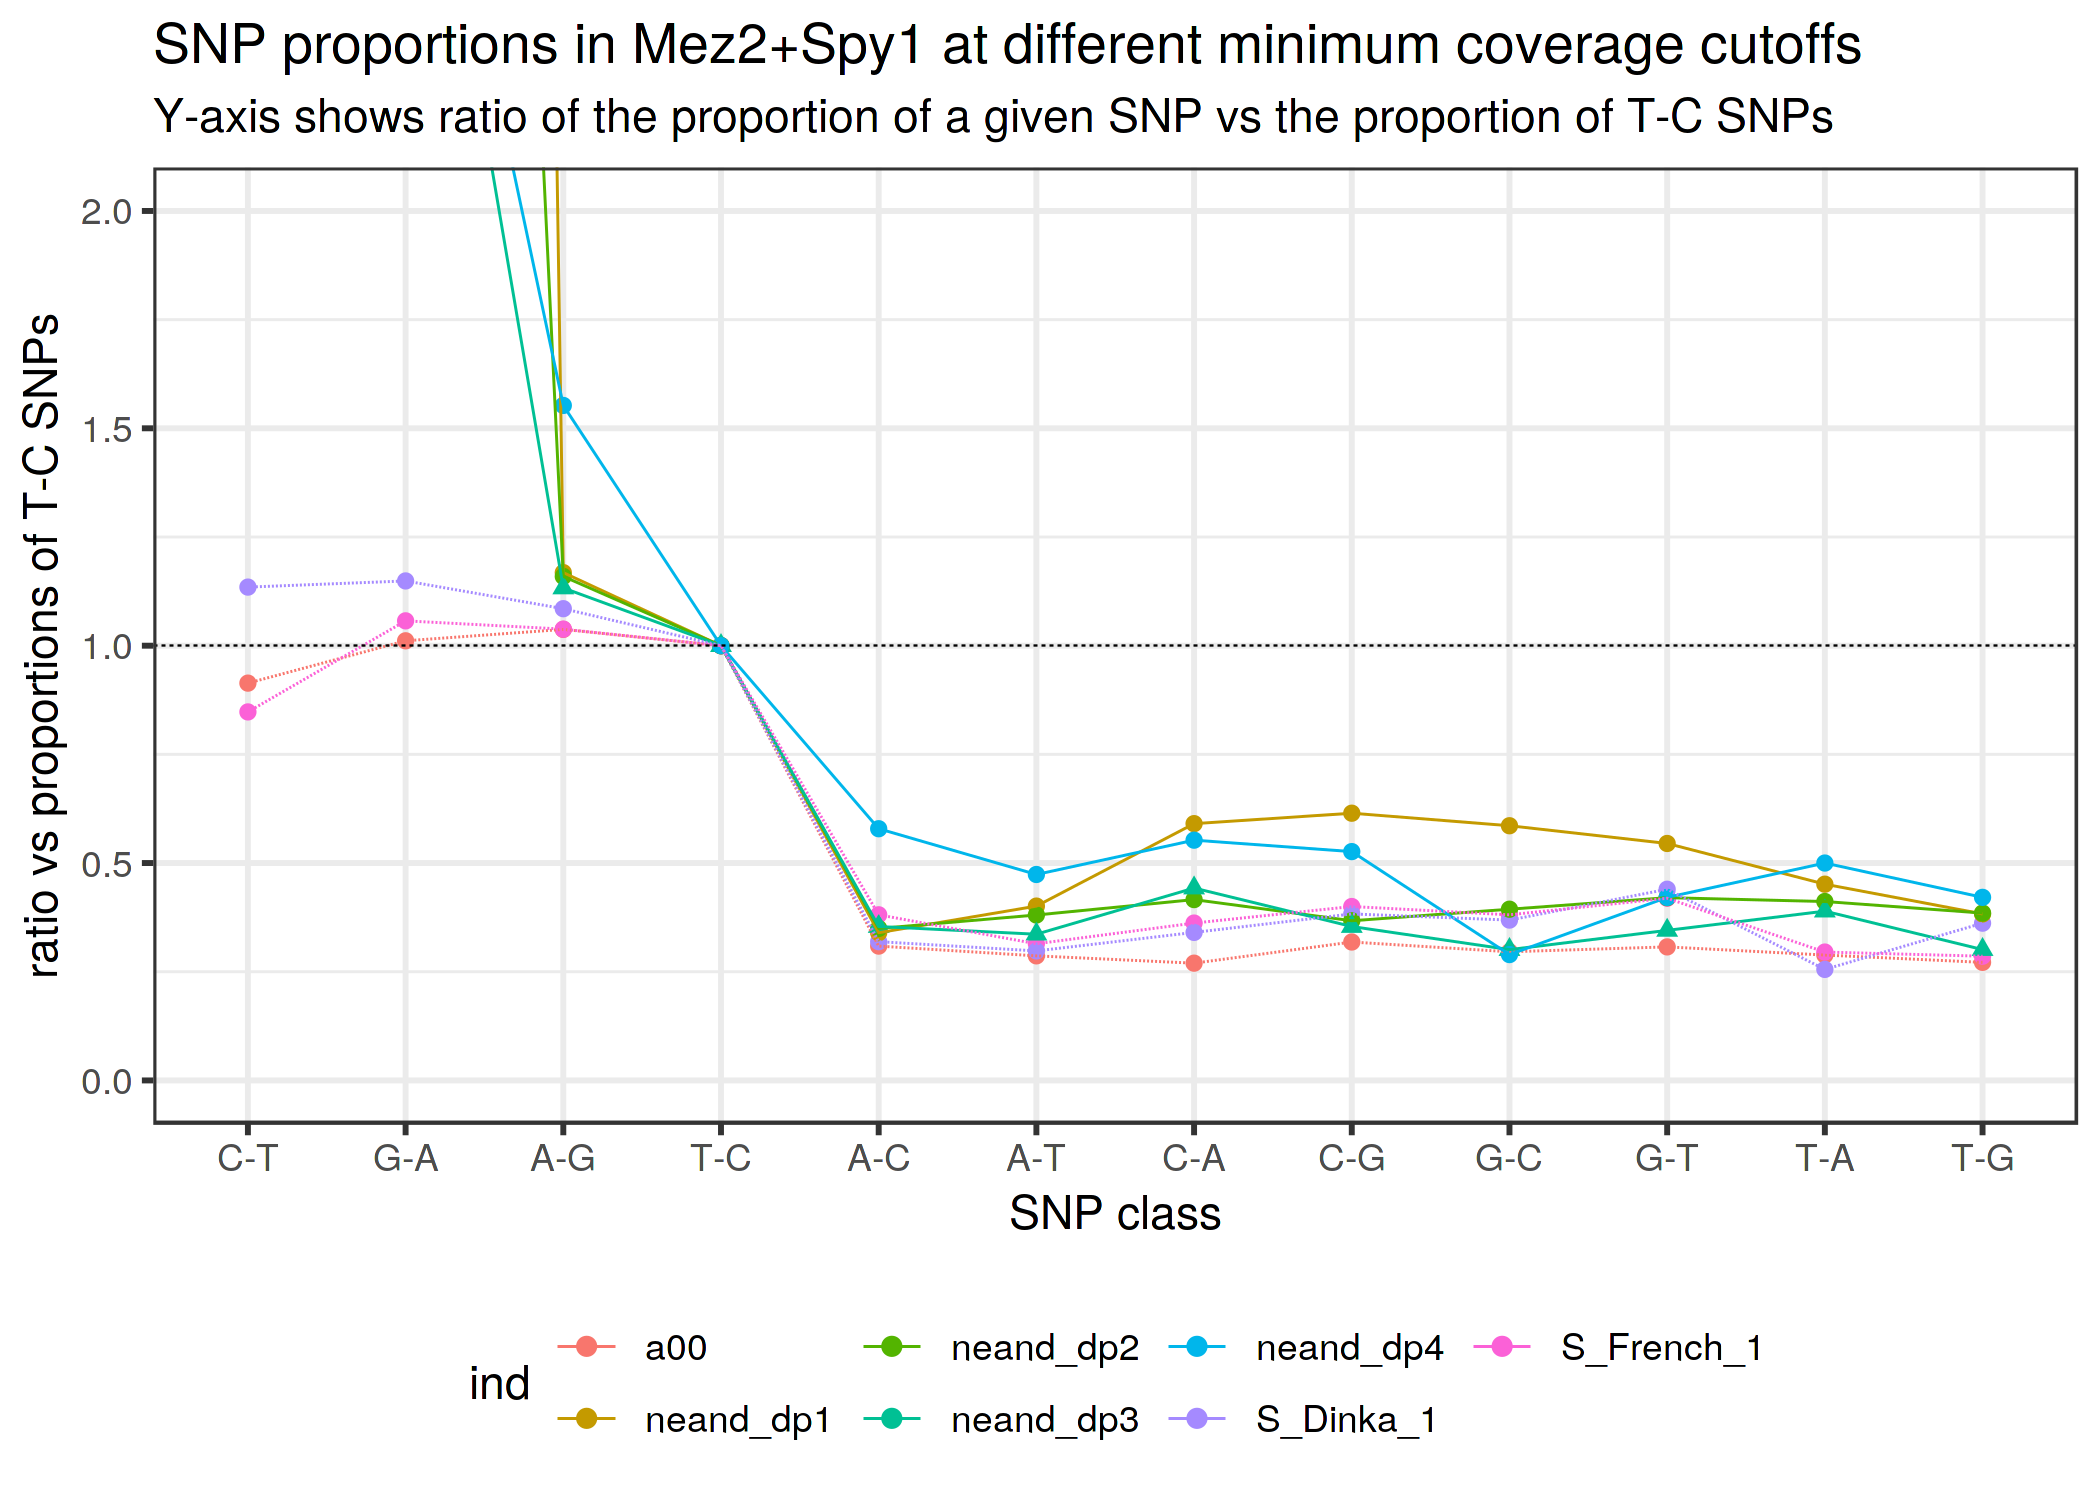

In [34]:
set_dim(7, 5)

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "den8")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = str_detect(ind, "dp3"))) +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() +
    xlab("SNP class") +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    ggtitle("SNP proportions in Mez2+Spy1 at different minimum coverage cutoffs",
            "Genotyping performed by consensus, requiring >= X reads at a site (dpX in the legend)")

test_props %>%
gather(ind, proportion, -snp) %>% filter(!str_detect(ind, "den8")) %>% 
ggplot(aes(fct_relevel(snp, c("C-T", "G-A", "A-G", "T-C")), proportion, color = ind)) +
    geom_point(aes(shape = str_detect(ind, "dp3"))) +
    geom_line(aes(group = ind, linetype = !str_detect(ind, "neand")), size = 0.25) +
    theme_bw() + ylab("ratio vs proportions of T-C SNPs") +
    xlab("SNP class") +
    geom_hline(yintercept = 1, linetype = 2, size = 0.2) +
    guides(linetype = FALSE, shape = FALSE) +
    theme(legend.position = "bottom") +
    coord_cartesian(y = c(0, 2)) +
    ggtitle("SNP proportions in Mez2+Spy1 at different minimum coverage cutoffs",
            "Y-axis shows ratio of the proportion of a given SNP vs the proportion of T-C SNPs")